# Investigate computation time of parts of the SO filter code

In [1]:
import matplotlib.pyplot as plt
import poligrain as plg
import xarray as xr

import pypwsqc

## Download example data

In this example, we use an open PWS dataset from Amsterdam, called the "AMS PWS" dataset. By running the cell below, an example NetCDF-file will be downloaded to your current repository (if your machine is connected to the internet).

In [2]:
!curl -OL https://github.com/OpenSenseAction/OS_data_format_conventions/raw/main/notebooks/data/OpenSense_PWS_example_format_data.nc

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 5687k  100 5687k    0     0  3007k      0  0:00:13  0:00:01  0:00:12  431k 0:00:01  0:00:01 --:--:-- 6130k


## Data preparations

This package handles rainfall data as `xarray`  Datasets. The data set must have `time` and `id` dimensions, `latitude` and `longitude` as coordinates, and `rainfall` as data variable.

An example of how to convert .csv data to a `xarray` dataset is found [here](https://github.com/OpenSenseAction/OS_data_format_conventions/blob/main/notebooks/PWS_example_dataset.ipynb).

In [3]:
ds_pws = xr.open_dataset("OpenSense_PWS_example_format_data.nc")
ds_pws

<xarray.Dataset>
Dimensions:    (time: 219168, id: 134)
Coordinates:
  * time       (time) datetime64[ns] 2016-05-01T00:05:00 ... 2018-06-01
  * id         (id) <U6 'ams1' 'ams2' 'ams3' ... 'ams132' 'ams133' 'ams134'
    elevation  (id) <U3 ...
    latitude   (id) float64 ...
    longitude  (id) float64 ...
Data variables:
    rainfall   (id, time) float64 ...
Attributes:
    title:                 PWS data from Amsterdam
    file author:           Maximilian Graf
    institution:           Wageningen University and Research, Department of ...
    date:                  2022-10-18 10:32:00
    source:                Netamo PWS
    history:               Data derived and reformated from the originally pu...
    naming convention:     OpenSense-0.1
    license restrictions:  CC-BY 4.0 https://creativecommons.org/licenses/by/...
    reference:             https://doi.org/10.1029/2019GL083731
    comment:

### Reproject coordinates 

First we reproject the coordinates to a local metric coordinate reference system to allow for distance calculations. In the Amsterdam example we use EPSG:25832. **Remember to use a local metric reference system for your use case!** We use the function `spatial.project_point_coordinates` in the `poligrain`package. 

In [4]:
ds_pws.coords["x"], ds_pws.coords["y"] = plg.spatial.project_point_coordinates(
    x=ds_pws.longitude, y=ds_pws.latitude, target_projection="EPSG:25832"
)

### Create distance matrix

Then, we calculate the distances between all stations in our data set. If your data set has a large number of stations this can take some time.

In [5]:
distance_matrix = plg.spatial.calc_point_to_point_distances(ds_pws, ds_pws)

### Check speed of getting data from neighors and do calculations

In [6]:
max_distance = 10e3

In [7]:
%%time
ds_pws = ds_pws.load()

CPU times: user 427 ms, sys: 248 ms, total: 675 ms
Wall time: 680 ms


In [8]:
npa_pws = ds_pws.rainfall.variable.values

In [9]:
%%time
nbrs_not_nan = []
reference = []

for pws_id in ds_pws.id.data:
    neighbor_ids = distance_matrix.id.data[
        (distance_matrix.sel(id=pws_id) < max_distance)
        & (distance_matrix.sel(id=pws_id) > 0)
    ]
    neighbor_index = (distance_matrix.sel(id=pws_id) < max_distance) & (distance_matrix.sel(id=pws_id) > 0)
    neighbor_index = neighbor_index.values

    # This takes approx 9 sec
    ds_pws_neighbors_rainfall = ds_pws.rainfall.sel(id=neighbor_ids)
    
    # no speedup from using .isel
    #ds_pws_neighbors_rainfall = ds_pws.rainfall.isel(id=neighbor_index)
    # also no speedup if indexing via numpy
    #ds_pws_neighbors_rainfall = ds_pws.rainfall.data[neighbor_index, :]
    # also no speedup from this
    #ds_pws.rainfall.variable.values[neighbor_index, :]
    # also no speedup when creating np array before and then do np indexing
    #npa_pws[neighbor_index, :]

    # This takes approx 4 sec
    N = ds_pws_neighbors_rainfall.isnull().sum(dim="id")
    nbrs_not_nan.append(N)

    # This takes approx 7 sec
    median = ds_pws_neighbors_rainfall.median(dim="id")
    reference.append(median)

#ds_pws["nbrs_not_nan"] = xr.concat(nbrs_not_nan, dim="id")
#ds_pws["reference"] = xr.concat(reference, dim="id")

CPU times: user 14.5 s, sys: 4.78 s, total: 19.2 s
Wall time: 19.5 s


In [102]:
ds_pws_neighbors_rainfall

<xarray.DataArray 'rainfall' (id: 24, time: 219168)>
array([[ 0.,  0.,  0., ..., nan, nan, nan],
       [ 0.,  0.,  0., ..., nan, nan, nan],
       [ 0.,  0.,  0., ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ...,  0.,  0.,  0.]])
Coordinates:
  * time       (time) datetime64[ns] 2016-05-01T00:05:00 ... 2018-06-01
  * id         (id) <U6 'ams89' 'ams90' 'ams92' ... 'ams130' 'ams131' 'ams133'
    elevation  (id) <U3 'nan' 'nan' 'nan' 'nan' ... 'nan' 'nan' 'nan' 'nan'
    latitude   (id) float64 52.29 52.29 52.3 52.29 ... 52.26 52.31 52.31 52.3
    longitude  (id) float64 4.907 4.907 4.909 4.911 ... 5.028 5.031 5.032 5.041
    x          (id) float64 2.209e+05 2.209e+05 ... 2.295e+05 2.301e+05
    y          (id) float64 5.801e+06 5.801e+06 ... 5.803e+06 5.802e+06
Attributes:
    name:                   rainfall
    long_name:              rainfall amount per time unit
    units:                  mm
    coverage_contant_type:  physicalMeasurement

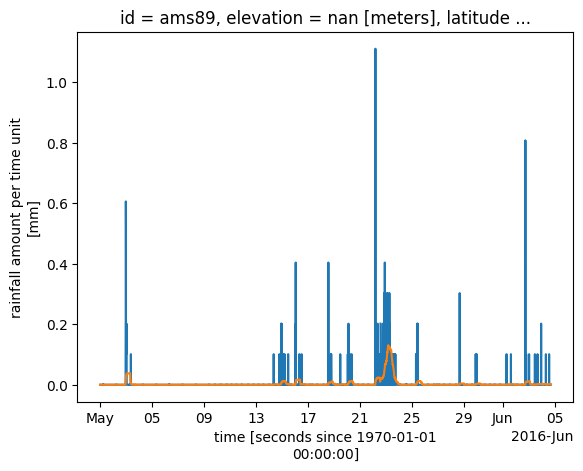

In [10]:
ds_pws_neighbors_rainfall.isel(id=0, time=slice(0, 10000)).plot()
ds_pws_neighbors_rainfall.isel(id=0, time=slice(0, 10000)).rolling(time=100, min_periods=1).mean().plot()
#ds_pws_neighbors_rainfall.isel(id=0, time=slice(0, 10000)).resample(time='1h').mean().plot()

### Try rolling window with xarray

In [11]:
rolling = ds_pws_neighbors_rainfall.rolling(time=1000).construct('window_dim') 

In [12]:
%%time
corr = xr.corr(rolling.isel(id=2), rolling.isel(id=1), dim='window_dim')
corr

CPU times: user 9.79 s, sys: 11.4 s, total: 21.2 s
Wall time: 25.4 s


<xarray.DataArray 'rainfall' (time: 219168)>
array([nan, nan, nan, ..., nan, nan, nan])
Coordinates:
  * time       (time) datetime64[ns] 2016-05-01T00:05:00 ... 2018-06-01
    elevation  <U3 'nan'

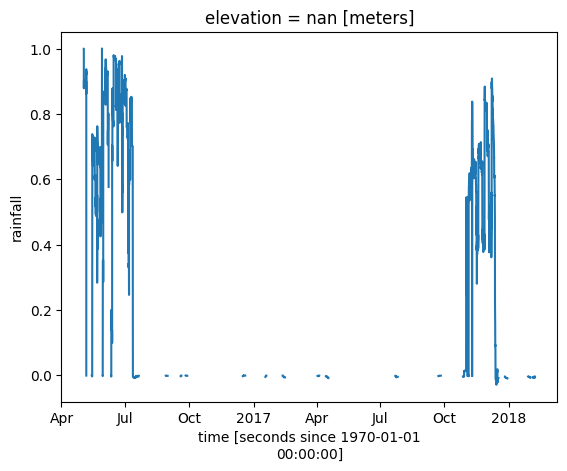

In [13]:
corr.plot()

### Try custom numpy function that works with the constructed array containing the windows along new dim

In [14]:
import numpy as np

def vec_corrcoef(X, y, axis=1):
    Xm = np.mean(X, axis=axis, keepdims=True)
    ym = np.mean(y)
    n = np.sum((X - Xm) * (y - ym), axis=axis)
    d = np.sqrt(np.sum((X - Xm)**2, axis=axis) * np.sum((y - ym)**2))
    return n / d

def vec_corrcoef(X, y, axis=1):
    Xm = np.nanmean(X, axis=axis, keepdims=True)
    ym = np.nanmean(y)
    n = np.nansum((X - Xm) * (y - ym), axis=axis)
    d = np.sqrt(np.nansum((X - Xm)**2, axis=axis) * np.nansum((y - ym)**2))
    return n / d

In [15]:
%%time
a = vec_corrcoef(rolling.isel(id=2).values, rolling.isel(id=1).values, axis=1)
a.shape

/var/folders/8f/z1lq69v144zb2p1_l1twh7kh0006md/T/ipykernel_26949/3028606358.py:11: RuntimeWarning: Mean of empty slice
  Xm = np.nanmean(X, axis=axis, keepdims=True)


CPU times: user 6.67 s, sys: 4.92 s, total: 11.6 s
Wall time: 11.8 s


/var/folders/8f/z1lq69v144zb2p1_l1twh7kh0006md/T/ipykernel_26949/3028606358.py:15: RuntimeWarning: invalid value encountered in divide
  return n / d


(219168,)

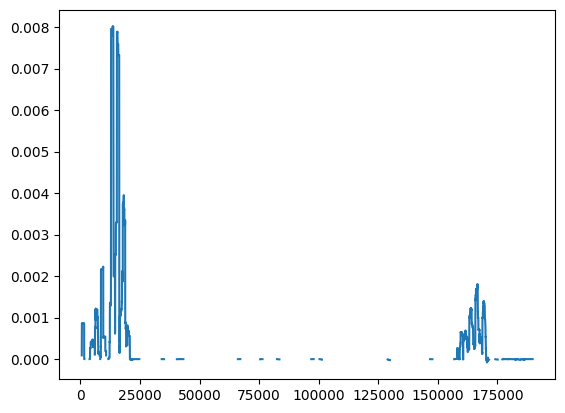

In [16]:
plt.plot(a)

In [17]:
%%time
a = vec_corrcoef(rolling.isel(id=slice(0, 3)).values, rolling.isel(id=1).values, axis=2)
a.shape

/var/folders/8f/z1lq69v144zb2p1_l1twh7kh0006md/T/ipykernel_26949/3028606358.py:11: RuntimeWarning: Mean of empty slice
  Xm = np.nanmean(X, axis=axis, keepdims=True)


CPU times: user 19.4 s, sys: 29.6 s, total: 49 s
Wall time: 1min


/var/folders/8f/z1lq69v144zb2p1_l1twh7kh0006md/T/ipykernel_26949/3028606358.py:15: RuntimeWarning: invalid value encountered in divide
  return n / d


(3, 219168)

In [18]:
a

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

### Try pandas rolling corr

- **This seems to be fastest by a large margin!**
- 300ms for rolling corr of two PWS time series, compared to 10 sec or more above with xarray- and numpy-based approaches

In [159]:
%%time

df_1 = ds_pws_neighbors_rainfall.isel(id=2).to_dataframe().rainfall
df_2 = ds_pws_neighbors_rainfall.isel(id=1).to_dataframe().rainfall

foo = df_1.rolling(1000, min_periods=1).corr(df_2)

CPU times: user 146 ms, sys: 29.2 ms, total: 175 ms
Wall time: 175 ms


Also seems to scale linearly, or even better, when using more then one time series as the input to `corr()`

In [161]:
%%time

df_1 = ds_pws_neighbors_rainfall.isel(id=10).to_dataframe().rainfall
#df_2 = ds_pws_neighbors_rainfall.isel(id=slice(2, 4)).to_dataframe().rainfall
df_2 = ds_pws_neighbors_rainfall.to_dataframe().rainfall

foo = df_1.rolling(1000, min_periods=1).corr(df_2)

CPU times: user 1.38 s, sys: 455 ms, total: 1.84 s
Wall time: 1.85 s


Transform rolling corr data back to xarray from pd.DataFrame

In [162]:
import pandas as pd
ds_foo = xr.Dataset.from_dataframe(pd.DataFrame({'corr': foo}))
ds_foo['id'] = ds_foo.id.astype(str)
ds_foo

<xarray.Dataset>
Dimensions:  (id: 24, time: 219168)
Coordinates:
  * id       (id) <U6 'ams89' 'ams90' 'ams92' ... 'ams130' 'ams131' 'ams133'
  * time     (time) datetime64[ns] 2016-05-01T00:05:00 ... 2018-06-01
Data variables:
    corr     (id, time) float64 nan nan nan nan ... 0.2802 0.2802 0.2802 0.2802

Plot corr and below also the daily rainfall sum of all stations in this data subset.

Note that ams90 was used as basis, hence it show perfect correlation with itself.

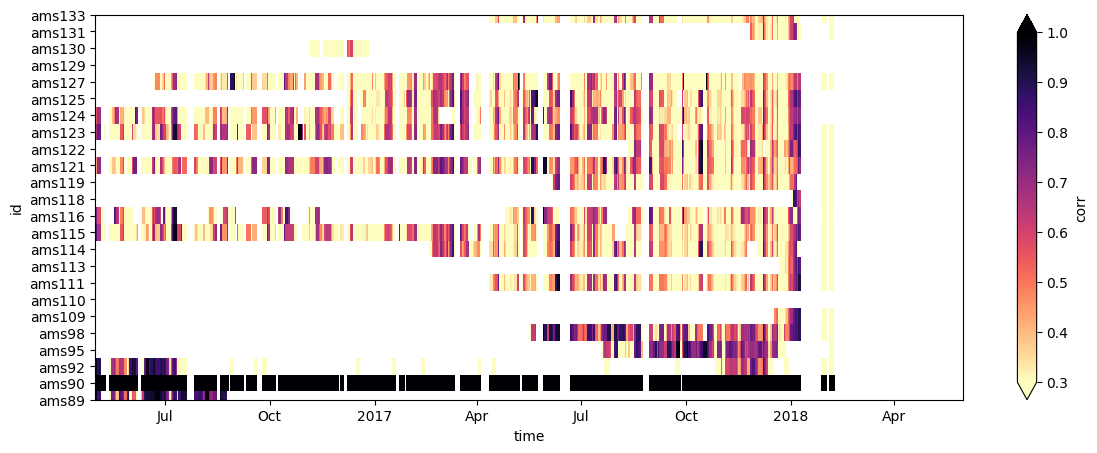

In [154]:
ds_foo.corr.resample(time='1d').median().plot.pcolormesh(cmap='magma_r', vmin=0.3, vmax=1, figsize=(14, 5));

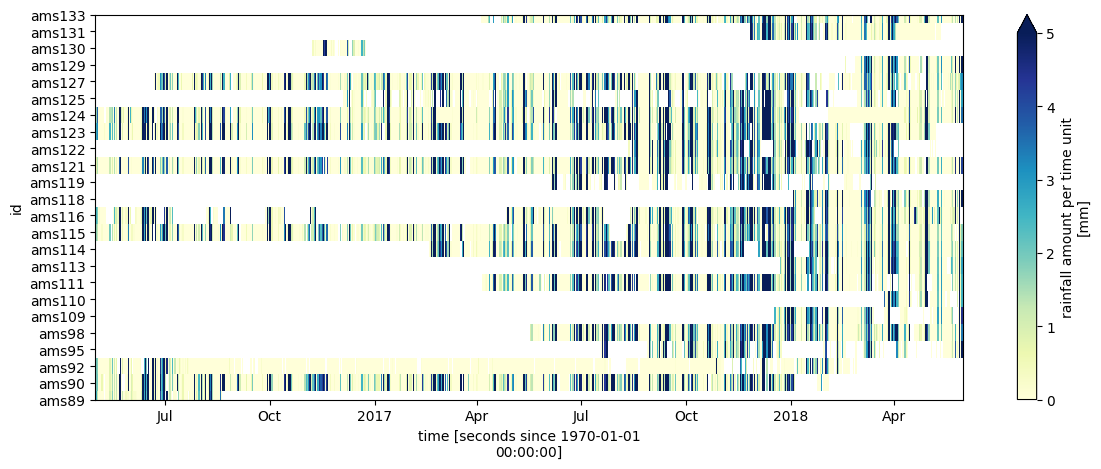

In [155]:
ds_pws_neighbors_rainfall.resample(time='1d').sum(min_count=12 * 23).plot.pcolormesh(cmap='YlGnBu', vmin=0, vmax=5, figsize=(14, 5));